In [39]:
%pip install --upgrade pip
%pip install pandas numpy openpyxl matplotlib seaborn
import pandas,numpy,os,re,datetime,random,itertools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Read excel files

In [40]:
def get_indice_name(file_name:str)->str:
    indices = [
            {'code':'^FCHI','name':'CAC40'},
            {'code':'^GSPC','name':'S&P 500'},
            {'code':'^HSI','name':'Hang Seng'},
            {'code':'MSCI','name':'MSCI Emerging Markets'},
            ]
    for indice in indices:
        if indice['code'] in file_name:
            return indice['name']
    return file_name


def load_data(directory:str)->dict:
    data = dict()
    
    for file_path in os.listdir(directory):
        print(file_path)
        try:
            if "MSCI" in file_path:
                df = pandas.read_csv(f'{directory}/{file_path}', sep=';')
            else:
                df = pandas.read_csv(f'{directory}/{file_path}')
            data[get_indice_name(file_path)] = df
        except Exception as error:  
            print(error)
    return data

In [41]:
data = load_data('./input')

.DS_Store
'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
MSCI_EM.csv
^FCHI.csv
^HSI.csv


In [42]:
print(data)

{'MSCI Emerging Markets':             Date    Close     Open     High      Low
0     05/26/2023   972.86   963.09   973.60   963.09
1     05/25/2023   964.01   970.42   973.38   962.53
2     05/24/2023   970.90   977.20   977.74   969.84
3     05/23/2023   978.60   983.84   985.86   977.19
4     05/22/2023   983.27   977.26   984.90   976.87
...          ...      ...      ...      ...      ...
2950  02/03/2012  1048.36  1043.92  1050.36  1039.83
2951  02/02/2012  1043.96  1032.93  1045.24  1032.87
2952  02/01/2012  1029.87  1018.01  1031.25  1014.52
2953  01/31/2012  1019.39  1007.23  1022.46  1006.48
2954  01/30/2012  1006.17  1018.59  1021.66  1001.98

[2955 rows x 5 columns], 'CAC40':             Date         Open         High          Low        Close  \
0     1990-03-01  1836.000000  1838.000000  1827.000000  1832.000000   
1     1990-03-02  1831.000000  1860.000000  1831.000000  1860.000000   
2     1990-03-05  1866.000000  1874.000000  1862.000000  1874.000000   
3     1990-03-0

# Clean the data

In [43]:
def clean_data(data:dict)->dict:
    new_dict = dict()
    for header,content in data.items():
        content = pandas.DataFrame(content)
        # Check that date format is correct
        if re.match("^\d{2}/\d{2}/\d{2}$",content.Date[0]):
            # Should transform data to yyyy-mm-dd
            content.Date = content.Date.apply(lambda x: pandas.to_datetime(x, format='%m/%d/%y').strftime('%Y-%m-%d'))
        elif re.match("^\d{2}/\d{2}/\d{4}$",content.Date[0]):
            # Should transform data to yyyy-mm-dd
            content.Date = content.Date.apply(lambda x: pandas.to_datetime(x, format='%m/%d/%Y').strftime('%Y-%m-%d'))
        

        kept_headers = list()
        for column_name in content.columns:
            if column_name.strip().upper() in ['CLOSE','DATE']:
                # Get date column
                if column_name.strip().upper() in ['DATE']:
                    # Sort by asc on date
                    content = content.sort_values(column_name, ascending=True)
                    # Add the date header to index
                    content = content.set_index(column_name)
                else:
                    # Add the headers corresponding to CLOSE
                    kept_headers.append(column_name)
        

        # Then should only keep Date and Close columns
        content = content.loc[:, kept_headers]
    
        # Drop all the NaN
        content = content.dropna()

        content.index = pandas.to_datetime(content.index)
        new_dict[header] = content
    return new_dict

In [44]:
cleaned_data = clean_data(data)

# Compute statistics

In [45]:
def monthly_data(cleaned_data:dict)->dict:
    # Compute monthly average return
    ## Each period is distinguished when the number in the middle switches
    results = dict()
    for header,df in cleaned_data.items():
        # for column_name in df.columns:
        #     # Compute the monthly percentage variation
        #     MPV = df[column_name].pct_change().resample('M').last().dropna()
        stats = list()
        first = True
        for index, row in df.iterrows():
            if first:
                first_day = row[0]
                month = index.month
                start_date = index
                first = False
            # If month change then
            if index.month != month:
                # Compute the percentage change with last day
                stats.append({
                    'start_date':start_date,
                    'end_date':end_date,
                    'start_price':first_day,
                    'last_price':last_day
                })
                first_day = row[0]
                month = index.month
                start_date = index
            
            last_day = row[0]
            end_date = index
        results[header]=stats
    return results


In [46]:
monthly_data = monthly_data(cleaned_data)

In [47]:
print(monthly_data)

{'MSCI Emerging Markets': [{'start_date': Timestamp('2012-01-30 00:00:00'), 'end_date': Timestamp('2012-01-31 00:00:00'), 'start_price': 1006.17, 'last_price': 1019.39}, {'start_date': Timestamp('2012-02-01 00:00:00'), 'end_date': Timestamp('2012-02-29 00:00:00'), 'start_price': 1029.87, 'last_price': 1079.44}, {'start_date': Timestamp('2012-03-01 00:00:00'), 'end_date': Timestamp('2012-03-30 00:00:00'), 'start_price': 1076.42, 'last_price': 1041.45}, {'start_date': Timestamp('2012-04-02 00:00:00'), 'end_date': Timestamp('2012-04-30 00:00:00'), 'start_price': 1047.72, 'last_price': 1026.02}, {'start_date': Timestamp('2012-05-01 00:00:00'), 'end_date': Timestamp('2012-05-31 00:00:00'), 'start_price': 1025.56, 'last_price': 906.3}, {'start_date': Timestamp('2012-06-01 00:00:00'), 'end_date': Timestamp('2012-06-29 00:00:00'), 'start_price': 893.86, 'last_price': 937.35}, {'start_date': Timestamp('2012-07-02 00:00:00'), 'end_date': Timestamp('2012-07-31 00:00:00'), 'start_price': 941.4, 'l

# Now we compute yearly statistics

In [48]:
def yearly_data(monthly_data):
    results = dict()
    for header,data in monthly_data.items():
        result = list()
        stats = list()
        for i,month in enumerate(data) :
            if i==0:
                current_year = month['start_date'].year
                start_price = month['start_price']

            previous_year = month['start_date'].year
            if previous_year != current_year:
                # Compute stats
                result.append({current_year:(end_price/start_price)-1})
                start_price = month['start_price']
                current_year = month['start_date'].year
            end_price=month['last_price']
        results[header]=result
    
    
    return results
            

In [49]:
yearly_data = yearly_data(monthly_data)

In [50]:
print(yearly_data)

{'MSCI Emerging Markets': [{2012: 0.0487293399723705}, {2013: -0.050267106160491015}, {2014: -0.04622703608401657}, {2015: -0.16955285062952274}, {2016: 0.0856952191485878}, {2017: 0.344096625980415}, {2018: -0.16576389788778023}, {2019: 0.1539759609909621}, {2020: 0.15845474772123724}, {2021: -0.046247338881362454}, {2022: -0.224661532225375}], 'CAC40': [{1990: -0.1763100436681223}, {1991: 0.17322255880398685}, {1992: 0.06166067976463996}, {1993: 0.23064401309503357}, {1994: -0.1787305201625814}, {1995: -0.00737049887221386}, {1996: 0.21342481758426146}, {1997: 0.32871063447053617}, {1998: 0.2974824680214041}, {1999: 0.43660514141048834}, {2000: 0.0015293626765040536}, {2001: -0.20250734515955093}, {2002: -0.3310882903245559}, {2003: 0.11357671617970033}, {2004: 0.06237763009994901}, {2005: 0.22293086126423844}, {2006: 0.16547909468663402}, {2007: -0.0006461499481460464}, {2008: -0.42022318364404754}, {2009: 0.17513266819700557}, {2010: -0.040660483805099235}, {2011: -0.18997093658144

In [51]:
dataframes = pandas.DataFrame()
for header,yearly_return in yearly_data.items():
    xs = list()
    ys = list()
    for a in yearly_return:
        for y,x in a.items():
            ys.append(y)
            xs.append(x)
    dataframes[header]=pandas.DataFrame(xs,index=ys)

dataframes.to_excel('output.xlsx')

# Now we should construct portfolios

In [52]:
def generate_weights(indexes_number):
    # Define the number of indexes and the step value
    num_indexes = indexes_number
    step = 0.05

    # Define the range of percentages to generate
    min_percent = 0
    max_percent = 1
    percent_range = range(int(min_percent/step), int(max_percent/step) + 1)

    # Generate all combinations of percentages using itertools.product()
    weight_combinations = itertools.product(percent_range, repeat=num_indexes)

    return [list(round(w*step,2) for w in weights) for weights in weight_combinations if sum(weights)*step == 1.0]


In [53]:
merged_df = dataframes.dropna()

# keep only rows with index above 2012
merged_df = merged_df[merged_df.index >= 2012]

# Create a storage df
portfolios_df = pandas.DataFrame()

weights_list = generate_weights(len(merged_df.columns))
for i,weights in enumerate(weights_list):
    # TO calculate the return of the portfolio,
    # we can use the weight
    # but to calculate the risk, we have to use covariance matrix
    returns = numpy.array([merged_df[mean_column] for mean_column in merged_df.columns])
    cov_matrix = numpy.cov(returns)
    # Portfolio standard deviation
    portfolio_std = numpy.sqrt(numpy.dot(numpy.dot(weights, cov_matrix), weights))
    # Calculate portfolio return
    portfolio_return = numpy.mean(numpy.dot(returns.T, weights))
    composition = str()
    portfolio_df = pandas.DataFrame({'return':portfolio_return,'risk':portfolio_std},index=[i])
    for weight,title in zip(weights,merged_df.columns):
        portfolio_df[title]=f"{round(weight*100)}%"
    portfolios_df = pandas.concat([portfolios_df,portfolio_df])


# Display statistics about analyzed data

In [54]:
#merged_df.describe().round(2).to_excel('statistics.xlsx')

# Draw the correlation matrix for the data

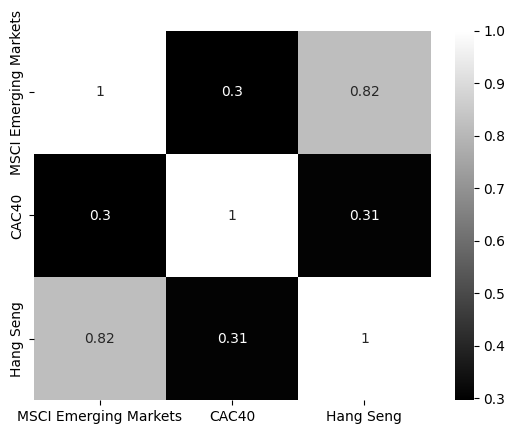

In [55]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = merged_df[merged_df.columns].corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='gray', annot=True)


# Save the heatmap to file
import matplotlib.pyplot as plt
plt.savefig('heatmap.png')

# Find most relevant portfolio

In [56]:
# Initialize excel writer to draw charts later
writer = pandas.ExcelWriter('portfolio.xlsx')
portfolios_df.to_excel(writer,sheet_name="portfolios",index=False)
# Get the index label of the portfolio with the lowest risk
min_risk_portfolio = portfolios_df['risk'].idxmin()

# Get the index label of the portfolio with the highest risk
max_risk_portfolio = portfolios_df['risk'].idxmax()

# Get the index label of the portfolio with the best Sharpe ratio
best_sharpe_portfolio = (portfolios_df['return']/portfolios_df['risk']).idxmax()

# Select the rows corresponding to the selected portfolios
selected_portfolios = portfolios_df.loc[[min_risk_portfolio, max_risk_portfolio, best_sharpe_portfolio]]
selected_portfolios.to_excel(writer,sheet_name="extremes",index=False)

writer.close()

In [57]:
sample = portfolios_df.sample(n=10, random_state=42)